In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

## Compute gradients in 2D

Mean div(m): 0.000148	Mean strain rate: 0.00129
Mean div(m): 0.000221	Mean strain rate: 0.00912
Mean div(m): 0.000418	Mean strain rate: 0.0393
Mean div(m): 0.000683	Mean strain rate: 0.0577


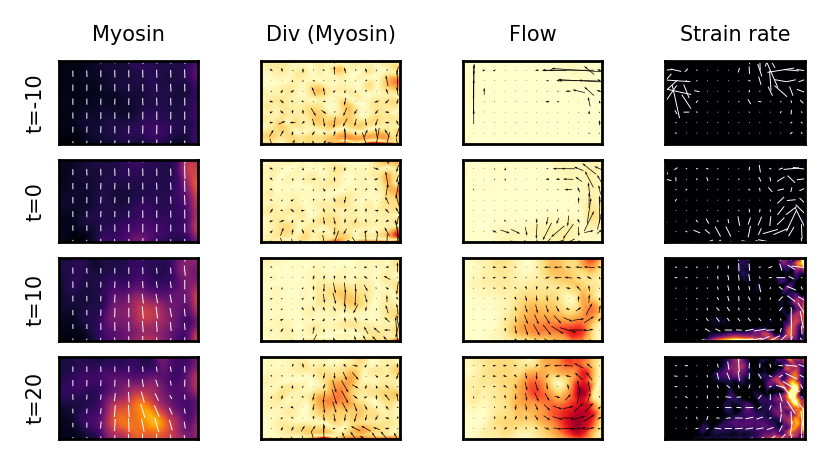

In [12]:
from utils.plot_utils import *
from utils.forecasting.transforms import EmbryoGradient, CovariantEmbryoGradient

def get_gradients_2D(m, v):
    gradient = EmbryoGradient(ap_mode='reflect').fit(v0)
    div_m = np.einsum('ijyxj->iyx', gradient.transform(m0))

    d1_v = gradient.transform(v0)
    E = 0.5 * (np.einsum('iyxj->ijyx', d1_v) + np.einsum('jyxi->ijyx', d1_v))
    
    return div_m, E

path = 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/'
df = pd.read_csv(os.path.join(path, 'dynamic_index.csv'))
of = pd.read_csv(os.path.join(path, 'morphodynamic_offsets.csv'), index_col='embryoID')
    
eId = df.embryoID.unique()[2]
m_full = np.load(os.path.join(path, str(eId), 'tensor2D.npy'), mmap_mode='r')
v_full = np.load(os.path.join(path, str(eId), 'velocity2D.npy'), mmap_mode='r')
t_full = df.loc[df.embryoID == eId, 'eIdx'].values - of.loc[eId, 'offset']

mnorm = np.linalg.norm(m_full, axis=(1, 2))
mmin = np.min(mnorm)
mmax = mmin + 7 * mnorm.std()

vmin = 0
vmax = np.max(np.linalg.norm(v_full, axis=1))

plt.rcParams['font.size'] = 6
plt.rcParams['axes.titlesize'] = 6
fig, ax = plt.subplots(4, 4, dpi=250, figsize=(4, 2), squeeze=False)

for i, t in enumerate([3, 13, 23, 33]):
    v0 = v_full[t]
    m0 = m_full[t]
    tt = t_full[t]

    div_m, E = get_gradients_2D(m0, v0)
    
    print(f'Mean div(m): {np.mean(np.linalg.norm(div_m, axis=0)):.3g}\tMean strain rate: {np.mean(np.linalg.norm(E, axis=(0, 1))):.3g}')

    plot_tensor2D(ax[i, 0], m0, vmin=mmin, vmax=mmax)
    
    color_2D(ax[i, 1], np.linalg.norm(div_m, axis=0), cmap='YlOrRd')
    plot_vector2D(ax[i, 1], div_m, skip=15)
    
    color_2D(ax[i, 2], np.linalg.norm(v0, axis=0), vmin=vmin, vmax=vmax, cmap='YlOrRd')
    plot_vector2D(ax[i, 2], v0, skip=15)
    
    plot_tensor2D(ax[i, 3], 1.5*E, vmin=mmin, vmax=mmax, skip=15)

    ax[i, 0].set_ylabel('t=%d' % tt)
    
ax[0, 0].set_title('Myosin')
ax[0, 1].set_title('Div (Myosin)')
ax[0, 2].set_title('Flow')
ax[0, 3].set_title('Strain rate');

## Translate to 3D and back to 2D

Gradient operators: 8.113226413726807 s
Myosin divergence: 0.112 s
Strain rate: 0.0559 s
Mean div(m): 0.000283	Mean strain rate: 0.00126
Myosin divergence: 0.111 s
Strain rate: 0.0553 s
Mean div(m): 0.000337	Mean strain rate: 0.00857
Myosin divergence: 0.112 s
Strain rate: 0.0557 s
Mean div(m): 0.000519	Mean strain rate: 0.0535
Myosin divergence: 0.111 s
Strain rate: 0.0553 s
Mean div(m): 0.000892	Mean strain rate: 0.0737


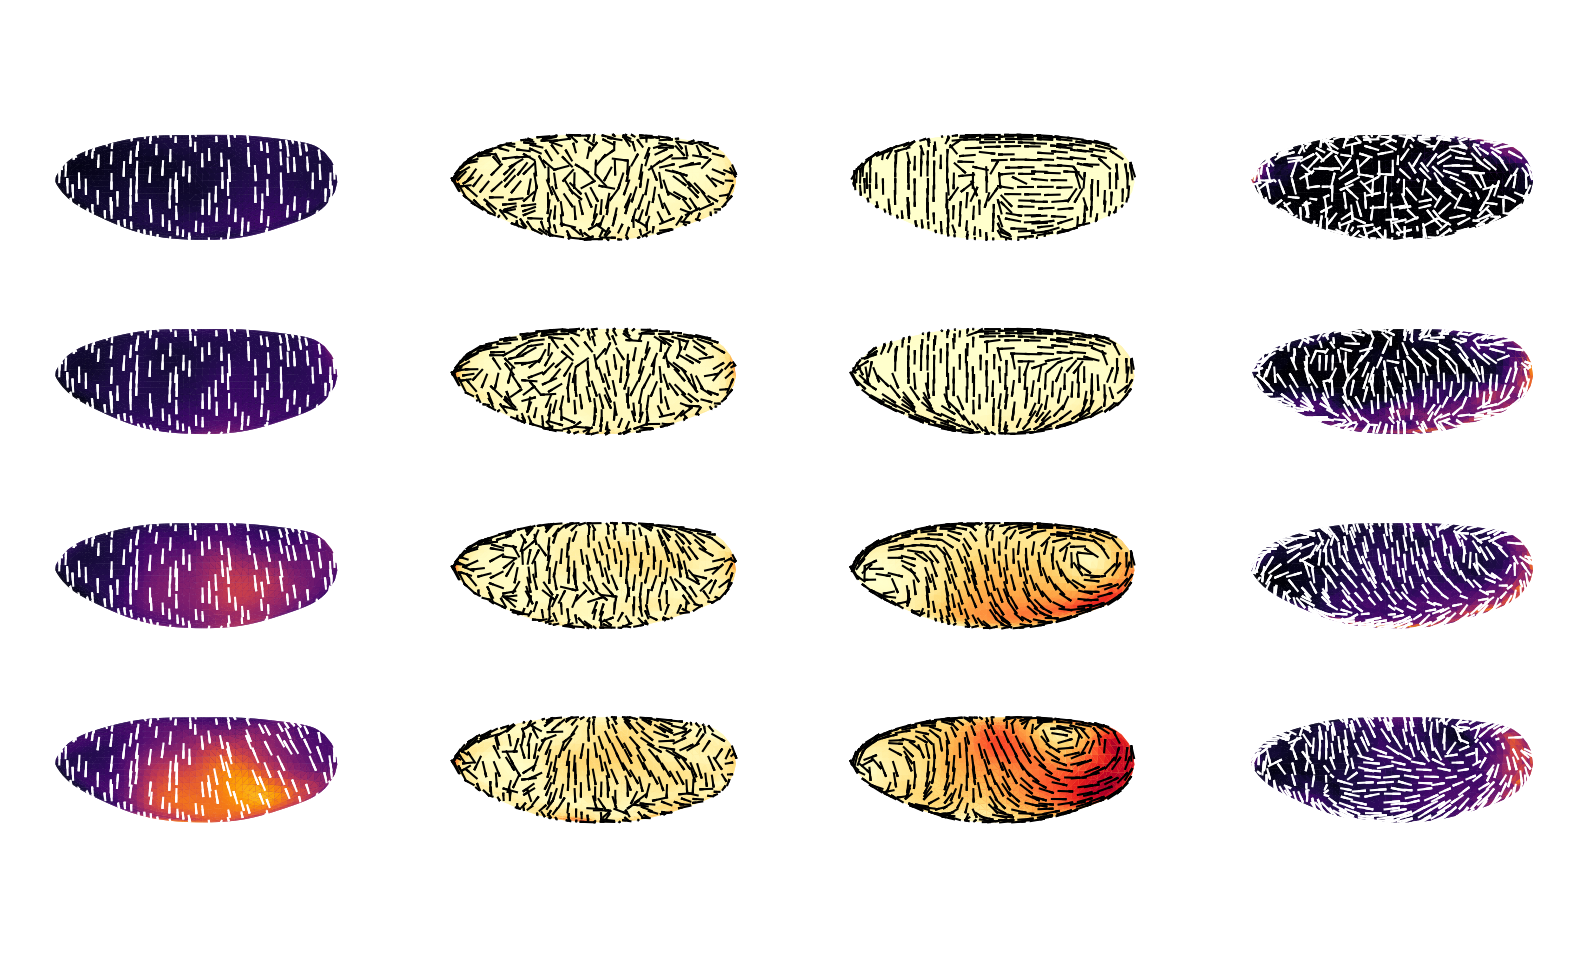

In [17]:
#Solve system exactly
from fenics import VectorElement

from utils.plot_utils import *
from utils.geometry.plot_utils import *
from utils.geometry.geometry_utils import *
from utils.geometry.fenics_utils import *

import time

t = time.time()
Ainv, grad_mat = build_gradient_operators(VectorElement('CG', embryo_mesh.ufl_cell(), 1))
print(f'Gradient operators: {time.time()-t} s')

def get_gradients_3D(m0, v0):
    #Compute myosin gradient
    t = time.time()
    
    m_verts = interpolate_grid_to_mesh_vertices(m0)
    grad = []
    for i in range(3):
        grad_ten = []
        for j in range(2):
            L = grad_mat[i].dot(m_verts[j].flatten())
            di = Ainv.dot(L)
            grad_ten.append(di)
        grad_ten = np.stack(grad_ten).reshape([2, 2, num_vertices])
        grad_ten = 0.5 * (grad_ten + np.einsum('ijv->jiv', grad_ten))
        grad.append(pull_tensor_from_tangent_space(grad_ten.flatten()))
    grad = np.stack(grad, axis=-1).reshape([3, 3, num_vertices, 3])
    div_m = np.einsum('ijvj->iv', grad)
    
    print(f'Myosin divergence: {time.time()-t:.3g} s')
    
    #Compute strain rate tensor
    t = time.time()

    v_verts = interpolate_grid_to_mesh_vertices(v0)
    grad = []
    for i in range(3):
        L = grad_mat[i].dot(v_verts.flatten())
        di = Ainv.dot(L)
        grad.append(pull_vector_from_tangent_space(di))

    grad = np.stack(grad, axis=-1).reshape([3, num_vertices, 3])
    E = 0.5 * (np.einsum('ivj->ijv', grad) + np.einsum('ivj->jiv', grad))
    
    print(f'Strain rate: {time.time()-t:.3g} s')
    
    m_verts = pull_from_tangent_space(m_verts)
    v_verts = pull_from_tangent_space(v_verts)

    
    return m_verts, div_m / 0.2619, v_verts, E / 0.2619

path = 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/'
df = pd.read_csv(os.path.join(path, 'dynamic_index.csv'))
of = pd.read_csv(os.path.join(path, 'morphodynamic_offsets.csv'), index_col='embryoID')
    
eId = df.embryoID.unique()[2]
m_full = np.load(os.path.join(path, str(eId), 'tensor2D.npy'), mmap_mode='r')
v_full = np.load(os.path.join(path, str(eId), 'velocity2D.npy'), mmap_mode='r')
t_full = df.loc[df.embryoID == eId, 'eIdx'].values - of.loc[eId, 'offset']

mnorm = np.linalg.norm(m_full, axis=(1, 2))
mmin = np.min(mnorm)
mmax = mmin + 7 * mnorm.std()

vmin = 0
vmax = np.max(np.linalg.norm(v_full, axis=1))

fig, ax = plt.subplots(4, 4, dpi=300, figsize=(8, 4), subplot_kw=dict(projection='3d'), squeeze=False)

div_m_1 = []
E_1 = []
for i, t in enumerate([3, 13, 23, 33]):
    v0 = v_full[t]
    m0 = m_full[t]
    tt = t_full[t]

    m0, div_m, v0, E = get_gradients_3D(m0[..., 20:-20], v0[..., 20:-20])
    
    print(f'Mean div(m): {np.mean(np.linalg.norm(div_m, axis=0)):.3g}\tMean strain rate: {np.mean(np.linalg.norm(E, axis=(0, 1))):.3g}')

    
    div_m_1.append(div_m)
    E_1.append(E)
    
    plot_tensor3D(ax[i, 0], m0, vmin=mmin, vmax=mmax)
    
    plot_vector3D(ax[i, 1], div_m)
    color_3D(ax[i, 1], np.linalg.norm(div_m, axis=0), cmap='YlOrRd')
        
    plot_vector3D(ax[i, 2], v0)
    color_3D(ax[i, 2], np.linalg.norm(v0, axis=0), vmin=vmin, vmax=vmax, cmap='YlOrRd')
    
    plot_tensor3D(ax[i, 3], E, skip=3)

fig.subplots_adjust(hspace=-0.4, wspace=-0.4)


Gradient operators: 65.26889872550964 s
Myosin divergence: 0.21352601051330566 s
Strain rate: 0.05729556083679199 s
Myosin divergence: 0.211273193359375 s
Strain rate: 0.05539536476135254 s
Myosin divergence: 0.2131044864654541 s
Strain rate: 0.05563998222351074 s
Myosin divergence: 0.21105384826660156 s
Strain rate: 0.05576586723327637 s


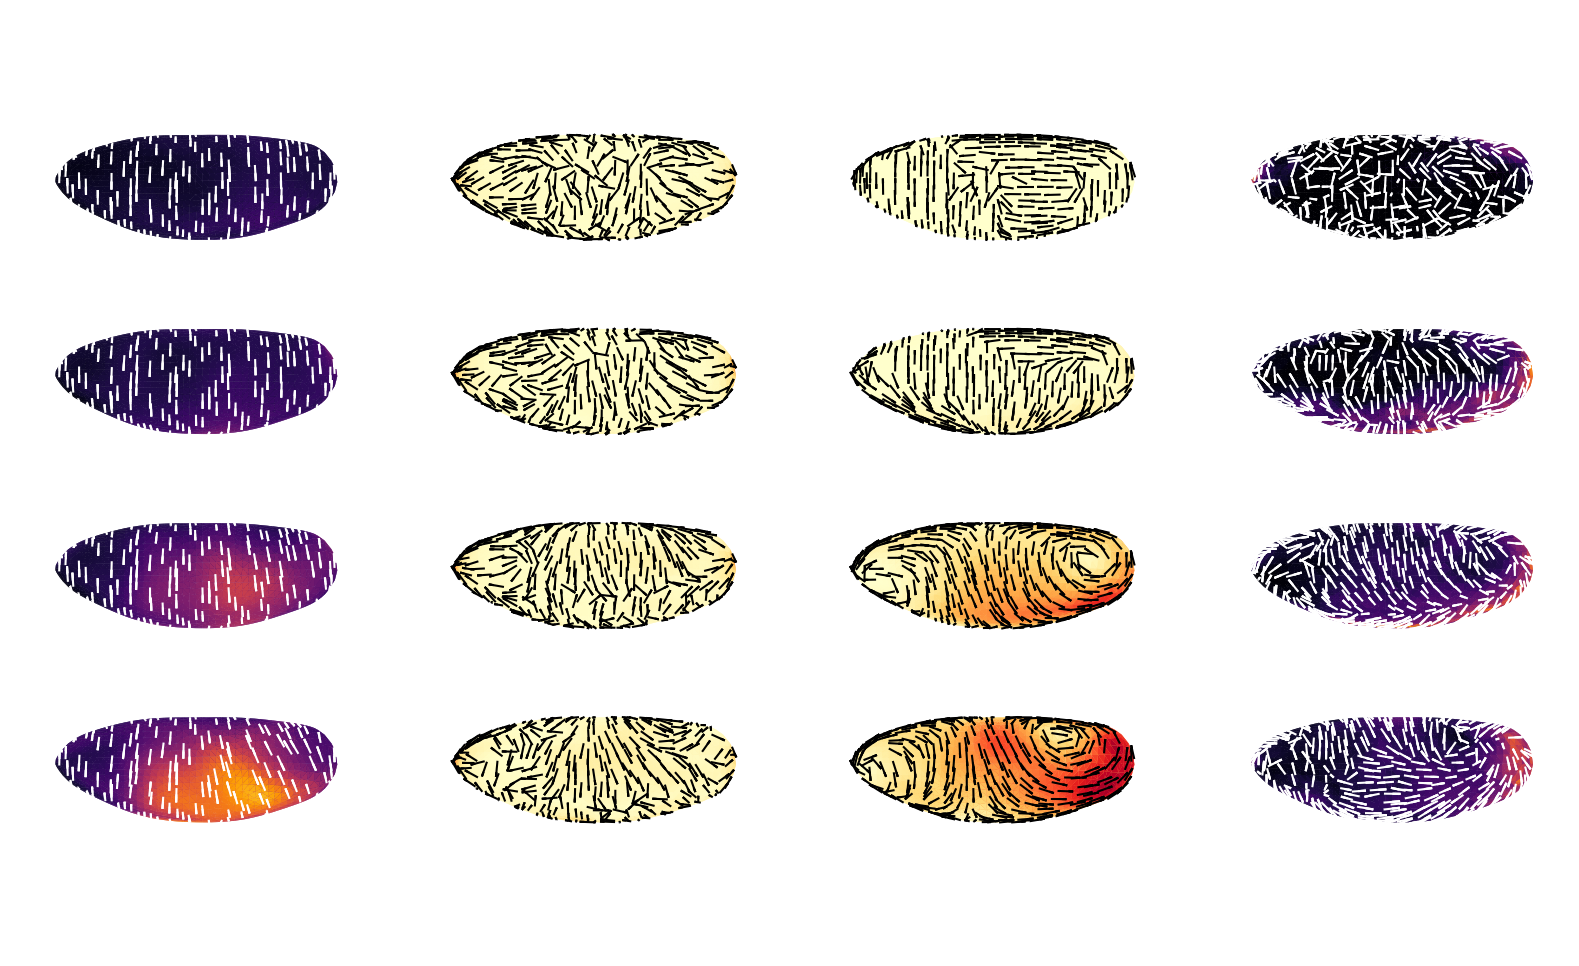

In [7]:
#Solve system exactly
from fenics import inner, dx
from fenics import TrialFunction, TestFunction
from fenics import FunctionSpace, TensorElement, VectorElement, FiniteElement
from fenics import Mesh
from fenics import assemble, vertex_to_dof_map

from scipy.sparse.linalg import spsolve

from utils.plot_utils import *
from utils.geometry.plot_utils import *
from utils.geometry.geometry_utils import *

import time

t = time.time()
A_vec, grad_vec = build_gradient_operators(VectorElement('CG', mesh.ufl_cell(), 1))
A_ten, grad_ten = build_gradient_operators(TensorElement('CG', mesh.ufl_cell(), 1))
print(f'Gradient operators: {time.time()-t} s')

def get_gradients_3D(m0, v0):
    #Compute myosin gradient
    t = time.time()
    
    m_verts = interpolate_grid_to_mesh_vertices(m0)
    grad = []
    for i in range(3):
        L = grad_ten[i].dot(m_verts.flatten())
        di = A_ten.dot(L)
        grad.append(pull_tensor_from_tangent_space(di))
    grad = np.stack(grad, axis=-1).reshape([3, 3, Nv, 3])
    div_m = np.einsum('ijvj->iv', grad)
    
    print(f'Myosin divergence: {time.time()-t} s')
    
    #Compute strain rate tensor
    t = time.time()

    v_verts = interpolate_grid_to_mesh_vertices(v0)
    grad = []
    for i in range(3):
        L = grad_vec[i].dot(v_verts.flatten())
        di = A_vec.dot(L)
        grad.append(pull_vector_from_tangent_space(di))

    grad = np.stack(grad, axis=-1).reshape([3, Nv, 3])
    E = 0.5 * (np.einsum('ivj->ijv', grad) + np.einsum('ivj->jiv', grad))
    
    print(f'Strain rate: {time.time()-t} s')
    
    m_verts = pull_from_tangent_space(m_verts)
    v_verts = pull_from_tangent_space(v_verts)

    
    return m_verts, div_m, v_verts, E

path = 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/'
df = pd.read_csv(os.path.join(path, 'dynamic_index.csv'))
of = pd.read_csv(os.path.join(path, 'morphodynamic_offsets.csv'), index_col='embryoID')
    
eId = df.embryoID.unique()[2]
m_full = np.load(os.path.join(path, str(eId), 'tensor2D.npy'), mmap_mode='r')
v_full = np.load(os.path.join(path, str(eId), 'velocity2D.npy'), mmap_mode='r')
t_full = df.loc[df.embryoID == eId, 'eIdx'].values - of.loc[eId, 'offset']

mnorm = np.linalg.norm(m_full, axis=(1, 2))
mmin = np.min(mnorm)
mmax = mmin + 7 * mnorm.std()

vmin = 0
vmax = np.max(np.linalg.norm(v_full, axis=1))

fig, ax = plt.subplots(4, 4, dpi=300, figsize=(8, 4), subplot_kw=dict(projection='3d'), squeeze=False)

div_m_2 = []
E_2 = []
for i, t in enumerate([3, 13, 23, 33]):
    v0 = v_full[t]
    m0 = m_full[t]
    tt = t_full[t]

    m0, div_m, v0, E = get_gradients_3D(m0[..., 20:-20], v0[..., 20:-20])
    
    div_m_2.append(div_m)
    E_2.append(E)
    
    plot_tensor3D(ax[i, 0], m0, vmin=mmin, vmax=mmax)
    
    plot_vector3D(ax[i, 1], div_m)
    color_3D(ax[i, 1], np.linalg.norm(div_m, axis=0), cmap='YlOrRd')
        
    plot_vector3D(ax[i, 2], v0)
    color_3D(ax[i, 2], np.linalg.norm(v0, axis=0), vmin=vmin, vmax=vmax, cmap='YlOrRd')
    
    plot_tensor3D(ax[i, 3], E, skip=3)

fig.subplots_adjust(hspace=-0.4, wspace=-0.4)

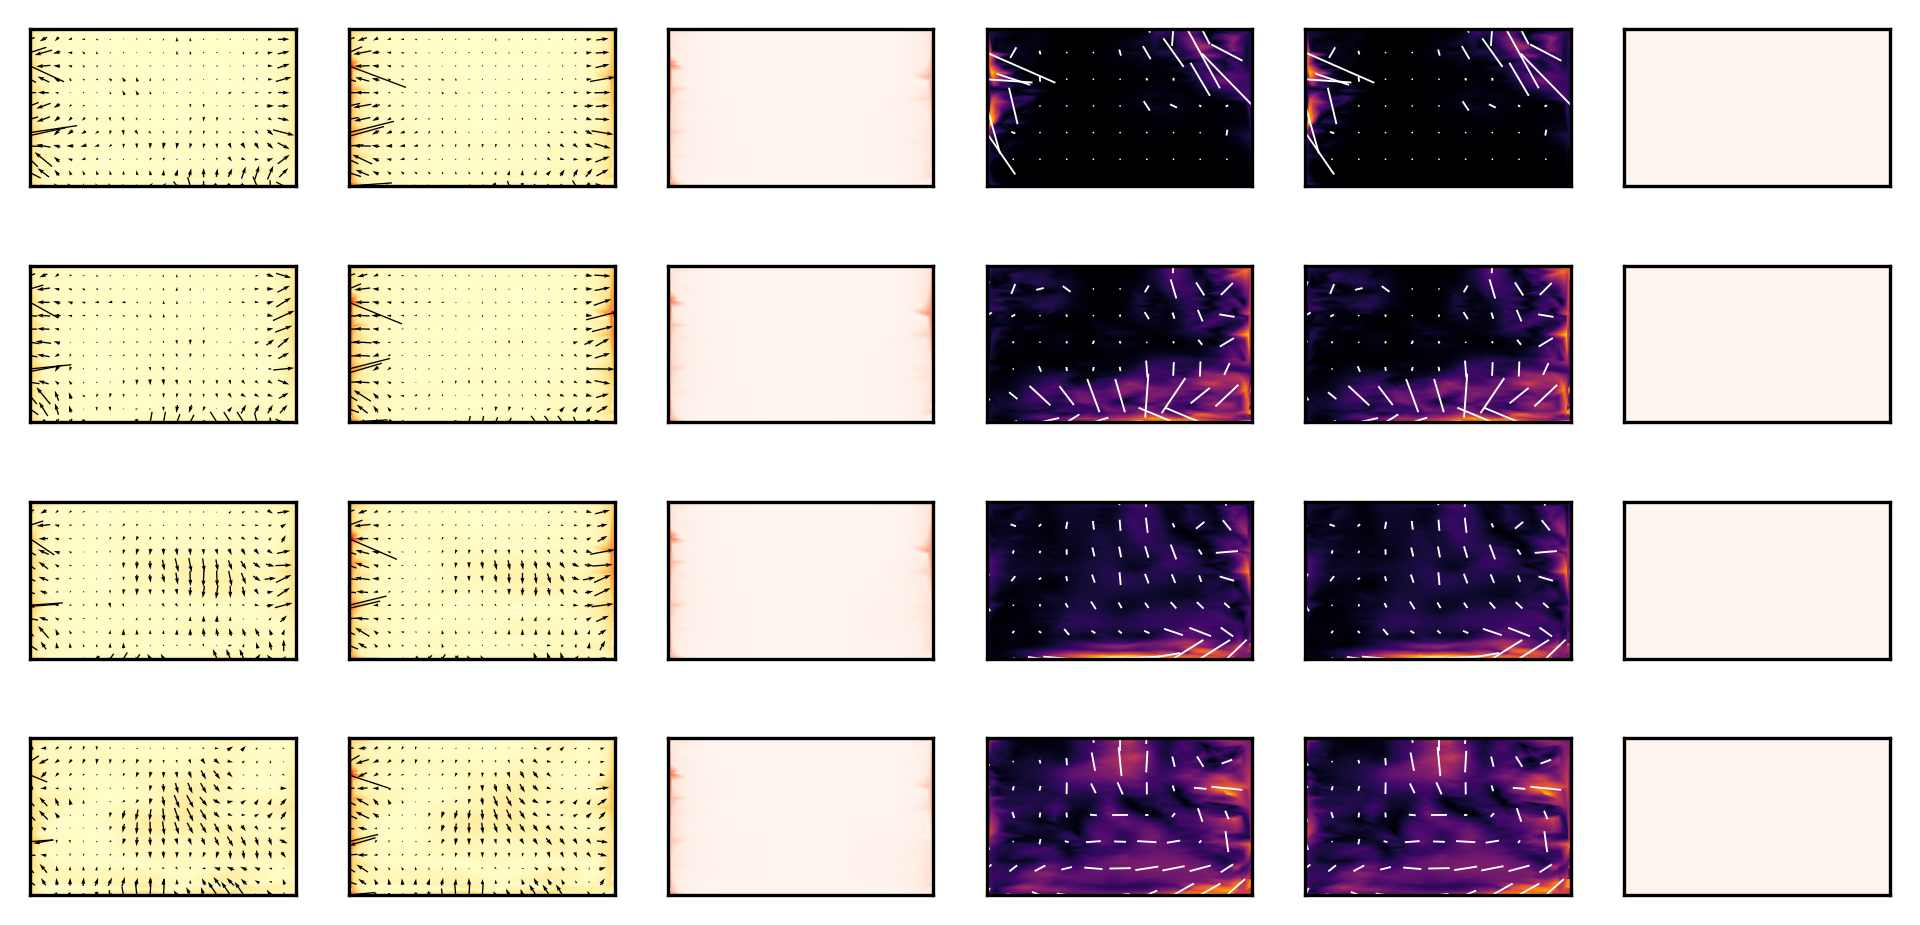

In [8]:
fig, ax = plt.subplots(4, 6, dpi=300, figsize=(8, 4), squeeze=False)

for i in range(4):
    div_m = push_to_tangent_space(div_m_2[i])
    mmax = np.max(np.linalg.norm(div_m, axis=0))
    mmin = np.min(np.linalg.norm(div_m, axis=0))

    plot_vector2D(ax[i, 0], push_to_tangent_space(div_m_1[i]))
    color_2D(ax[i, 0], np.linalg.norm(push_to_tangent_space(div_m_1[i]), axis=0), vmin=mmin, vmax=mmax, cmap='YlOrRd')

    plot_vector2D(ax[i, 1], push_to_tangent_space(div_m_2[i]))
    color_2D(ax[i, 1], np.linalg.norm(push_to_tangent_space(div_m_2[i]), axis=0), vmin=mmin, vmax=mmax, cmap='YlOrRd')
    
    err = np.linalg.norm(div_m_1[i] - div_m_2[i], axis=0)
    err = interpolate_mesh_vertices_to_grid(err)
    color_2D(ax[i, 2], err, vmin=mmin, vmax=mmax, cmap='Reds')
    
    plot_tensor2D(ax[i, 3], push_to_tangent_space(E_1[i]))
    plot_tensor2D(ax[i, 4], push_to_tangent_space(E_2[i]))
    
    err = np.linalg.norm(E_1[i] - E_2[i], axis=(0, 1))
    err = interpolate_mesh_vertices_to_grid(err)
    color_2D(ax[i, 5], err, vmin=0, cmap='Reds')